In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

from matplotlib.ticker import FormatStrFormatter
from glob import glob
from os.path import join
from scipy import interpolate
from urllib.request import urlopen

import itertools
import datetime
import time
import sys  

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

# vol = '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/'
vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

In [3]:
gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Wed Jul 22 10:35:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   32C    P8    14W / 250W |     62MiB / 12212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                      

# Background

**Question:** What is the temperature at the levels between the surface and altitude of the highest equalibrium level?

---
# Data Quality Report

In [2]:
# dqrid, startime, endtime, metric, subjec
# using same timeformat as that used in ARM filenames

datastream = 'sgpsondewnpnC1.b1'
varname = 'dp'
dqrfields = 'starttime,endtime,metric,subject' #dqrid
timeformat= 'YYYYMMDD.hhmmss'
searchmetric = 'incorrect,suspect'

url = ''.join(('http://www.archive.arm.gov/dqrws/ARMDQR',
               '?datastream=', datastream, '&varname=', varname,
               '&dqrfields=', dqrfields, '&timeformat=', timeformat,
               '&searchmetric=', searchmetric))

response = urlopen(url)

suspect, incorrect = {}, {}

if response.getcode() == 200:
    for line in response.readlines():
        line = line.decode()
        for ii in ['\n', '\r']: line = line.replace(ii, '')
        print(line)
else: 
    print(response.getcode())

20050801.113200|20050801.131636|incorrect|SGP/SONDE/C1 - Bad T/RH and surface P.
20041002.113000|20041002.113100|incorrect|SGP/SONDE/C1 - Incorrect surface temperature
20090106.173000|20090106.191418|suspect|SGP/SONDE/C1 - Suspect RH values
20150416.232800|20150417.004322|incorrect|SGP/SONDE/C1 - RH sensor failure
20020612.053300|20020612.053300|incorrect|SGP/SONDE/C1 - Sensor failure
20060913.113100|20060913.143100|suspect|SGP/SONDE/C1 - Suspect RH profile from 150-350 m above ground level
20060912.113100|20060912.143100|suspect|SGP/SONDE/C1 - Suspect RH profile from 150-350 m above ground level
20060911.053200|20060911.083200|suspect|SGP/SONDE/C1 - Suspect RH profile from 150-350 m above ground level
20060905.113100|20060905.143100|suspect|SGP/SONDE/C1 - Suspect RH profile from 150-350 m above ground level
20060904.173100|20060904.203100|suspect|SGP/SONDE/C1 - Suspect RH profile from 150-350 m above ground level
20060904.113400|20060904.143400|suspect|SGP/SONDE/C1 - Suspect RH profil

`D040415.2|20040413.122900|20040413.130100|incorrect|SGP/SONDE/C1 - Temperature sensor broke high into the sounding
` is at the end of `2004/sgpsondewnpnC1.b1.20040413.113300.cdf`

---
# Data Loader

In [5]:
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2
ALTITUDE = 3

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= 1000 and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

In [157]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

In [5]:
fp = FloatProgress(min=0, max=(len(files)))
display(fp)

profiles = []
valid_profile_files = []

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        profile = np.concatenate((xar.pres.values.reshape(-1,1),
                                  xar.tdry.values.reshape(-1,1),
                                  xar.dp.values.reshape(-1,1),
                                  xar.alt.values.reshape(-1,1)), axis=1)
        profiles.append(profile)
        valid_profile_files.append(f)
    xar.close()
    fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')

FloatProgress(value=0.0, max=27209.0)

time: 395.128, avg: 0.015 seconds


In [6]:
len(profiles), profiles[0].shape, profiles[-1].shape

(25460, (3574, 4), (2884, 4))

---
# Preprocess

## EL for All Profiles

In [7]:
is_valid = np.ones(len(profiles), dtype=bool)
els = np.zeros(len(profiles))
alts = np.zeros(len(profiles))

fp = FloatProgress(min=0, max=(len(profiles)))
display(fp)

s = time.time()
for i, profile in enumerate(profiles):
    sounding_dict = dict()
    sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = profile[:, PRESSURE]
    sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = profile[:, TEMPERATURE]
    sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = profile[:, DEWPOINT]
    try:
        el_p, _ = radiosonde_products.el(sounding_dict)
        if np.isnan(el_p):
            is_valid[i] = False
        else: 
            els[i] = el_p
            # altitude of pressure value at the EL
            alts[i] = profile[:, ALTITUDE][(np.abs(profile[:, PRESSURE] - el_p)).argmin()]
    except:
        is_valid[i] = False
        
    fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f} seconds')

FloatProgress(value=0.0, max=25460.0)

/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: invalid value encountered in true_divide
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: divide by zero encountered in true_divide
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0
/s/chopin/l/grad/stock/.local/lib/python3.7/site-packages/metpy/calc/tools.py:156: RuntimeWarning: invalid value encountered in multiply
  intersect_y = ((intersect_x - x0) / (x1 - x0)) * (a1 - a0) + a0


time: 3269.437 seconds


In [8]:
valid_els = els[is_valid]
print(f'{valid_els.shape}, mean: {valid_els.mean():.2f}, std: {valid_els.std():.2f}, max: {valid_els.max():.2f}, min: {valid_els.min():.2f}')

(11529,), mean: 386.37, std: 269.25, max: 991.20, min: 71.80


In [9]:
alts_el = alts[is_valid]
print(f'{alts_el.shape}, mean: {alts_el.mean():.2f}, std: {alts_el.std():.2f}, max: {alts_el.max():.2f}, min: {alts_el.min():.2f}')
print(f'max EL alt: {alts_el[valid_els.argmax()]:.2f}, min EL alt: {alts_el[valid_els.argmin()]:.2f}')

(11529,), mean: 9017.33, std: 4621.06, max: 19374.00, min: 314.80
max EL alt: 315.00, min EL alt: 19374.00


In [10]:
# np.save(vol + '../profiles-alt.npy', np.array(profiles))
# with open(vol + '../profiles-alt-files.txt', 'w') as f:
#     for item in valid_profile_files:
#         f.write("%s\n" % item)

In [144]:
# profiles = np.load(vol + '../profiles-alt.npy', allow_pickle=True)
# valid_profile_files = np.loadtxt(vol + '../profiles-alt-files.txt', dtype=str)

### Isolating profiles with a high EL

In [131]:
valid_profile_files_n = valid_profile_files[is_valid]
profiles_n = profiles[is_valid]

In [133]:
els_n.shape, valid_profile_files_n.shape, profiles_n.shape

((10665,), (10665,), (10665,))

In [135]:
min_profile = np.nanargmin(valid_els)

profile = profiles_n[min_profile]
sounding_dict = dict()
sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = profile[:, PRESSURE]
sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = profile[:, TEMPERATURE]
sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = profile[:, DEWPOINT]
el_p, _ = radiosonde_products.el(sounding_dict)

valid_els[min_profile], el_p, valid_profile_files_n[min_profile]

(71.79910689772912,
 71.79910689772912,
 '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2005/sgpsondewnpnC1.b1.20050909.113200.cdf')

## Filter Profiles by $A_{el}$

In [152]:
alt_el = 21_000. # slightly above the altitude of the minimum EL

In [153]:
is_valid = np.ones(len(profiles), dtype=bool)

# fp = FloatProgress(min=0, max=(len(profiles)))
# display(fp)

s = time.time()
for i, profile in enumerate(profiles):
    # does not reach the altitude of the minimum EL
    if profile[-1, ALTITUDE] < alt_el:
        is_valid[i] = False
    # fp.value += 1
    
e = time.time() - s
print(f'time: {e:.3f} seconds')

time: 0.048 seconds


In [154]:
valid_profile_files.shape, profiles.shape

((25460,), (25460,))

In [155]:
profiles = np.asarray(profiles)[is_valid]
valid_profile_files = np.asarray(valid_profile_files)[is_valid]
valid_profile_files.shape, profiles.shape

((23237,), (23237,))

In [158]:
print(f'Total of {valid_profile_files.shape[0]} / {len(files)} valid files')

Total of 23237 / 27209 valid files


##  Intopolate Values Between [sfc, $A_{el}$]

In [159]:
SONDE_PROFILE_DIMS = 2048

In [160]:
alt_s = profiles[0][0, ALTITUDE] # 315
altitude_intervals = np.linspace(alt_s, alt_el, SONDE_PROFILE_DIMS)

In [161]:
def interpolate_to_height_intervals(alt, y, altitude_intervals):
    f = interpolate.interp1d(alt, y)
    return f(altitude_intervals)

In [162]:
interpolated_profiles = np.zeros((len(profiles), SONDE_PROFILE_DIMS, 4))
for i in range(len(profiles)):
    
    # remove duplicate values at surface level 
    alt_s = profiles[i][0, ALTITUDE]
    start_indx = 0
    for j in range(1, len(profiles[i][:, ALTITUDE])):
        if profiles[i][j, ALTITUDE] == alt_s:
            start_indx = j
        else:
            break
            
    p_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, PRESSURE], altitude_intervals)
    t_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, TEMPERATURE], altitude_intervals)
    td_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, DEWPOINT], altitude_intervals)
    
    interpolated_profiles[i] = np.concatenate(([p_n], [t_n], [td_n], [altitude_intervals])).T

In [163]:
interpolated_profiles.shape

(23237, 2048, 4)

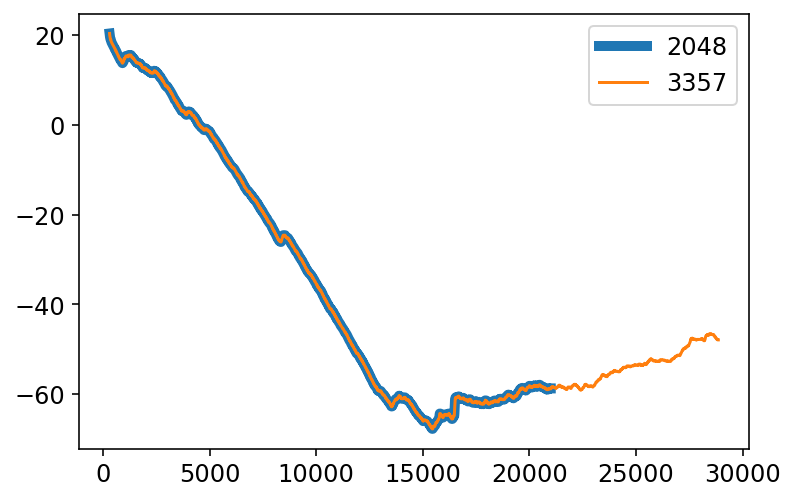

In [164]:
i = 2
plt.plot(interpolated_profiles[i, :, ALTITUDE], interpolated_profiles[i, :, TEMPERATURE], lw=5,
         label=str(len(interpolated_profiles[i, :, ALTITUDE])))
plt.plot(profiles[i][:, ALTITUDE], profiles[i][:, TEMPERATURE],
         label=str(len(profiles[i][:, ALTITUDE])))
plt.legend();

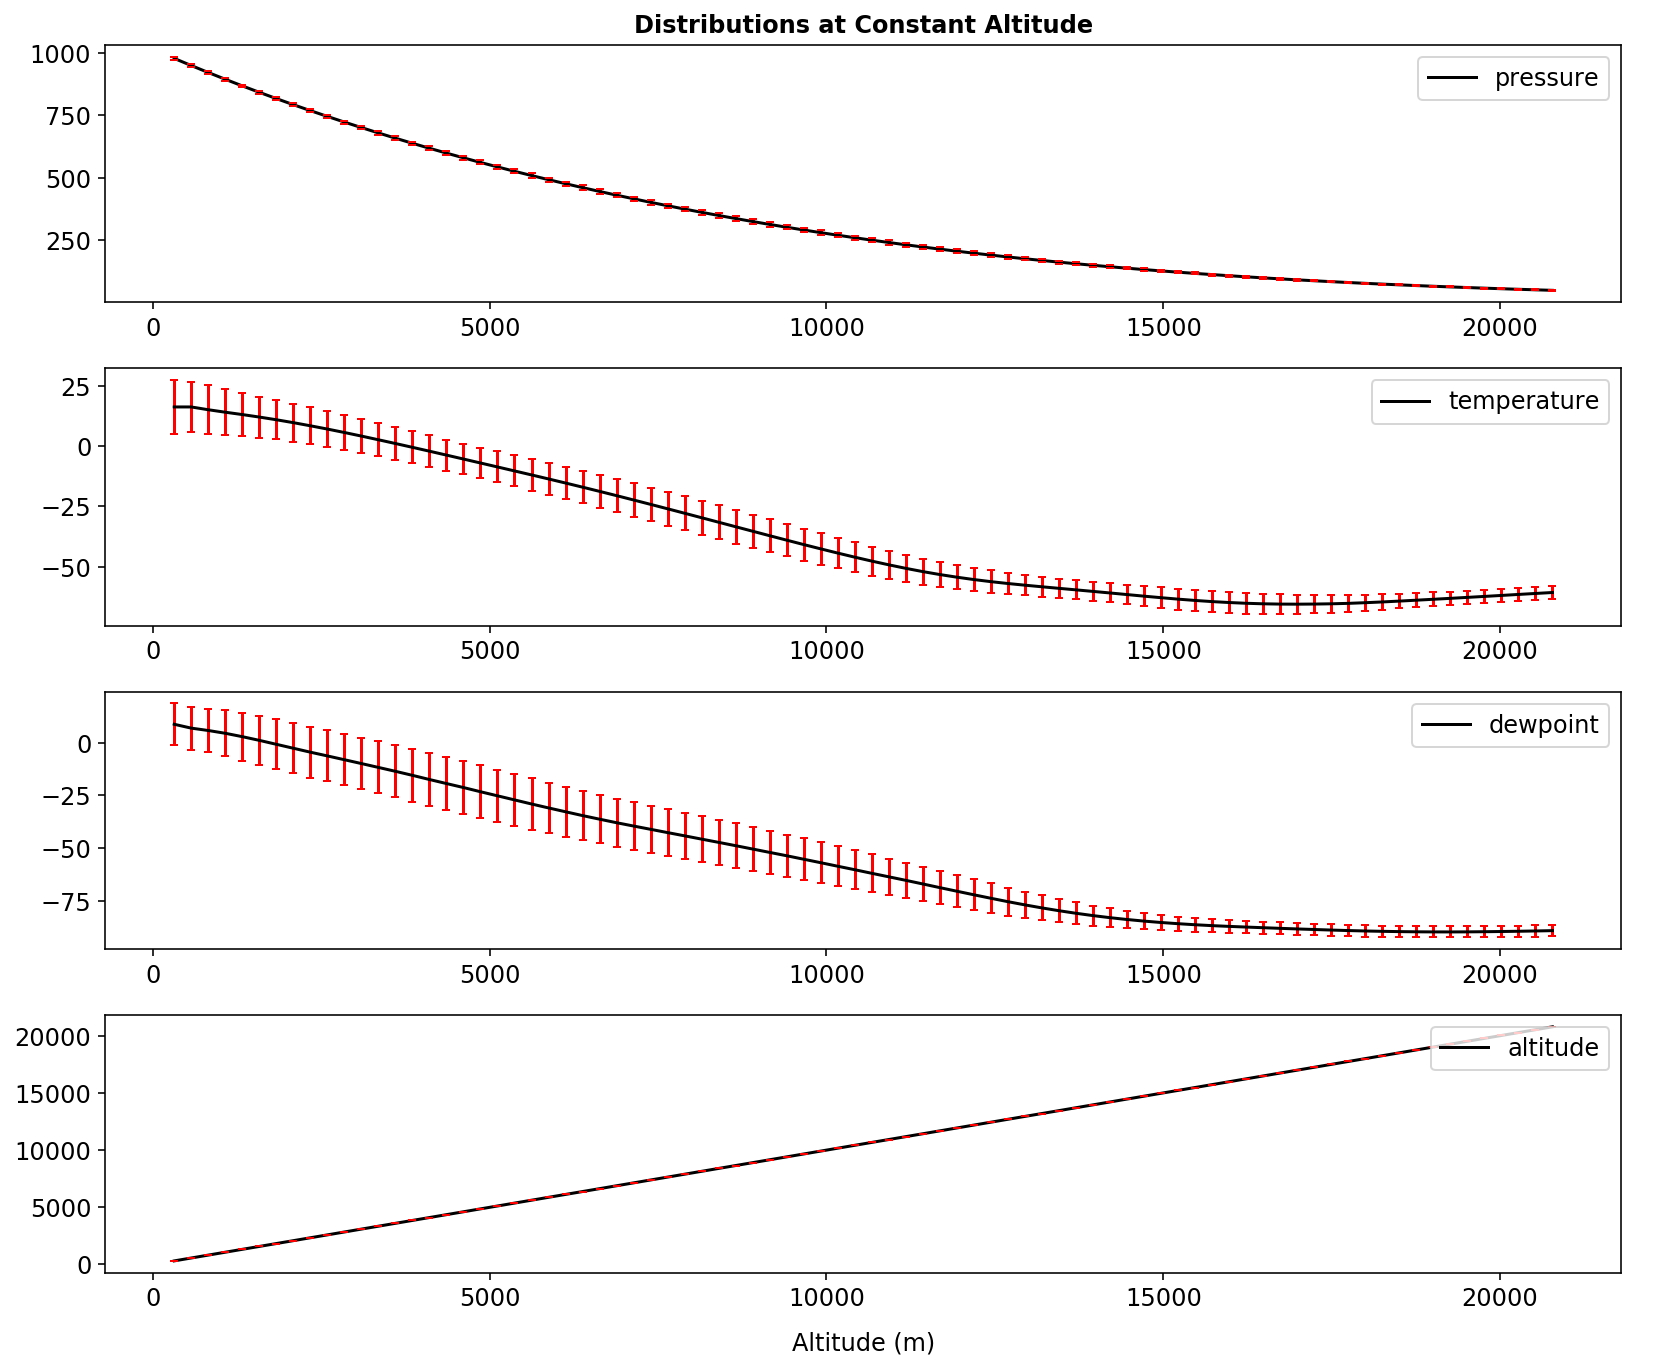

In [41]:
input_dims = [PRESSURE, TEMPERATURE, DEWPOINT, ALTITUDE]
labels = ['pressure', 'temperature', 'dewpoint', 'altitude']

fig, axs = plt.subplots(len(input_dims), figsize=(12, 10))
axs = axs.ravel()
interval = 25
for dim in input_dims:
    
    mu = np.mean(interpolated_profiles[:,:,dim], axis=0)[::interval]
    std = np.std(interpolated_profiles[:,:,dim], axis=0)[::interval]

    axs[dim].plot(altitude_intervals[::interval], mu, 'k', label=labels[dim])
    axs[dim].errorbar(altitude_intervals[::interval], mu, std, color='r', linestyle='None', capsize=2);
    axs[dim].legend(loc=1)
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Altitude (m)', labelpad=10)
plt.title('Distributions at Constant Altitude', y=1.0, fontweight='bold')

fig.tight_layout();         

In [166]:
# np.save(vol + '../profiles-alt-processed.npy', interpolated_profiles)
# with open(vol + '../profiles-alt-files-processed.txt', 'w') as f:
#     for item in valid_profile_files:
#         f.write("%s\n" % item)

In [2]:
interpolated_profiles = np.load(vol + '../profiles-alt-processed.npy')
valid_profile_files = np.loadtxt(vol + '../profiles-alt-files-processed.txt', dtype=str)
interpolated_profiles.shape, valid_profile_files.shape

((23237, 2048, 4), (23237,))

In [4]:
np.save(vol + '../SINGLE-profiles-alt-processed.npy', interpolated_profiles[1:2,...])

---
# Basic CAE

In [7]:
def plot_results(nnet, X, T, index=0, loss=True):

    P = X[index,:,PRESSURE]
        
    sounding_dict_for_metpy = dict()
    sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = P
    sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = T[index,:]
    sounding_dict_for_metpy[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(X[index:index+1,:])[0]
    
    radiosonde_plotting.plot_predicted_sounding(sounding_dict_for_metpy)
    if loss:
        fig, ax = plt.subplots(1, figsize=(8, 4))

        ax.plot(nnet.history['loss'], label='train')
        ax.plot(nnet.history['val_loss'], label='val')
        ax.legend();
    
def mean_pressure_errors(nnet, X, T):
    error = np.abs((nnet.use(X) - T))
    pressures = X[:,:,PRESSURE]
    # Create linearly spaced bins from the min to max pressure
    bins = np.linspace(pressures.min(), pressures.max() + 1, pressures.shape[1])
    # Indicies of where which bin pressure values belong
    pressure_bin_indicies = np.digitize(pressures, bins)
    
    mean_error = np.zeros(bins.size)
    # Mean error corresponding to each bin of pressure levels
    for bin_index in range(bins.size):
        vals = error[pressure_bin_indicies == bin_index]
        mean = np.mean(vals) if vals.size > 0 else 0
        mean_error[bin_index] = mean
        
    # trim mean 0's from ends
    s = 0
    for i in range(mean_error.size):
        if mean_error[i] != 0:
            s = i
            break
    e = mean_error.size
    for i in range(mean_error.size-1, 0, -1):
        if mean_error[i] != 0:
            e = i
            break

    mean_error = mean_error[s:e+1]
    bins = bins[s:e+1]
    
    return mean_error, bins

def plot_altitude_rmse(nnet, X, T):
    alt_s = interpolated_profiles[0, 0, ALTITUDE]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs = axs.ravel()
    Y = nnet.use(X)
    rmse = np.sqrt((np.mean((Y - T)**2, axis=0)))
    mean_rmse = ml.rmse(Y, T)

    axs[0].plot(altitude_intervals, rmse)
    axs[0].hlines(mean_rmse, altitude_intervals[0], altitude_intervals[-1],
                  'k', '--', label=f'{mean_rmse:.3f}')
    
    surface_error = 100
    axs[1].plot(altitude_intervals[:surface_error], rmse[:surface_error])
    axs[1].hlines(mean_rmse, altitude_intervals[:surface_error][0], 
                  altitude_intervals[:surface_error][-1], 'k', '--')

    axs[0].set_xlabel('Altitude (m)')
    axs[1].set_xlabel('Altitude (m)')
    axs[0].set_ylabel('RMSE (C)')
    axs[0].legend();

In [8]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(interpolated_profiles, interpolated_profiles,
                                            (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((18590, 2048, 3), (18590, 2048), (4647, 2048, 3), (4647, 2048))

In [9]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(10, 1)]*4,
                                   Ttrain.shape[1], activation='relu',
                                   n_hidden_dims=128, seed=1234)
# nnet.model.summary()
nnet.train(Xtrain, Ttrain, 20, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.12171
epoch: 5, loss: 0.00788
epoch: 10, loss: 0.00495
epoch: 15, loss: 0.00409
epoch: 19, loss: 0.00336
finished!


ConvolutionalAutoEncoder((2048, 3), [4, 4, 8, 8], [(10, 1), (10, 1), (10, 1), (10, 1)], 2048)
  Final objective value is 0.00336 in 332.8088 seconds.

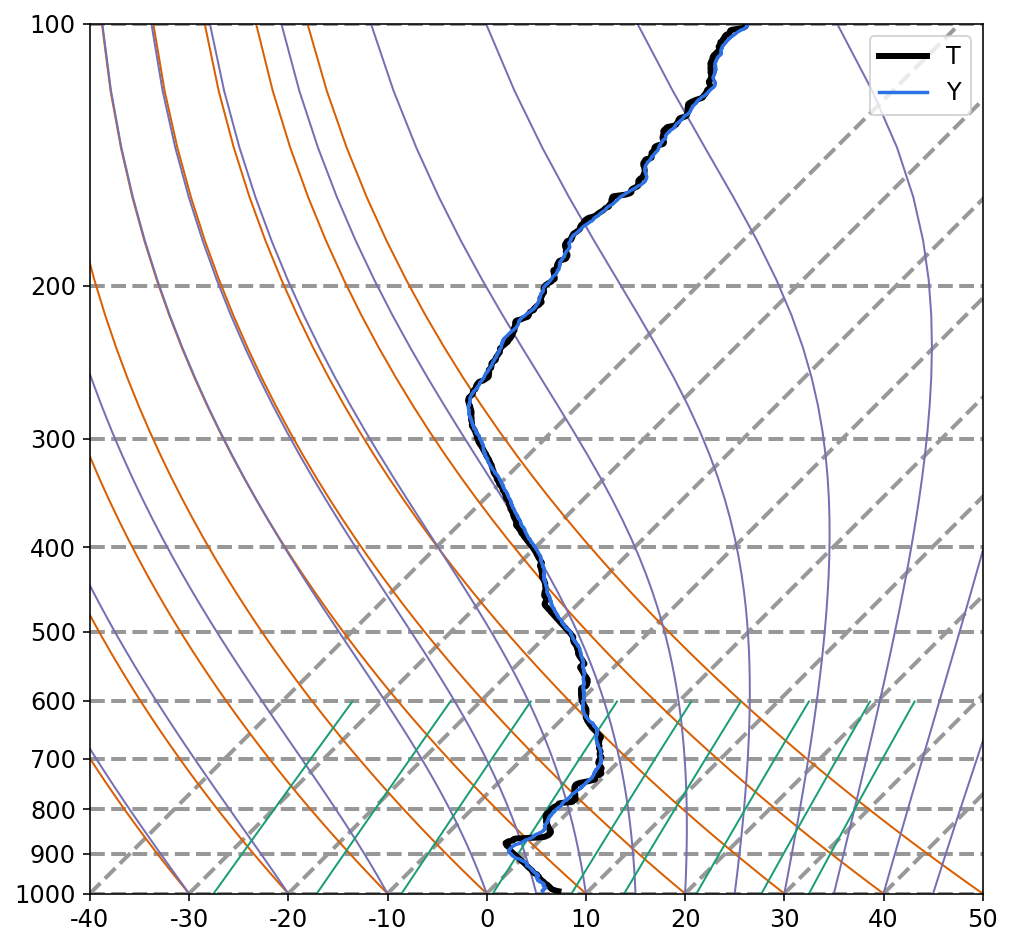

In [142]:
plot_results(nnet, Xtest, Ttest, 26, loss=False) #11, 17

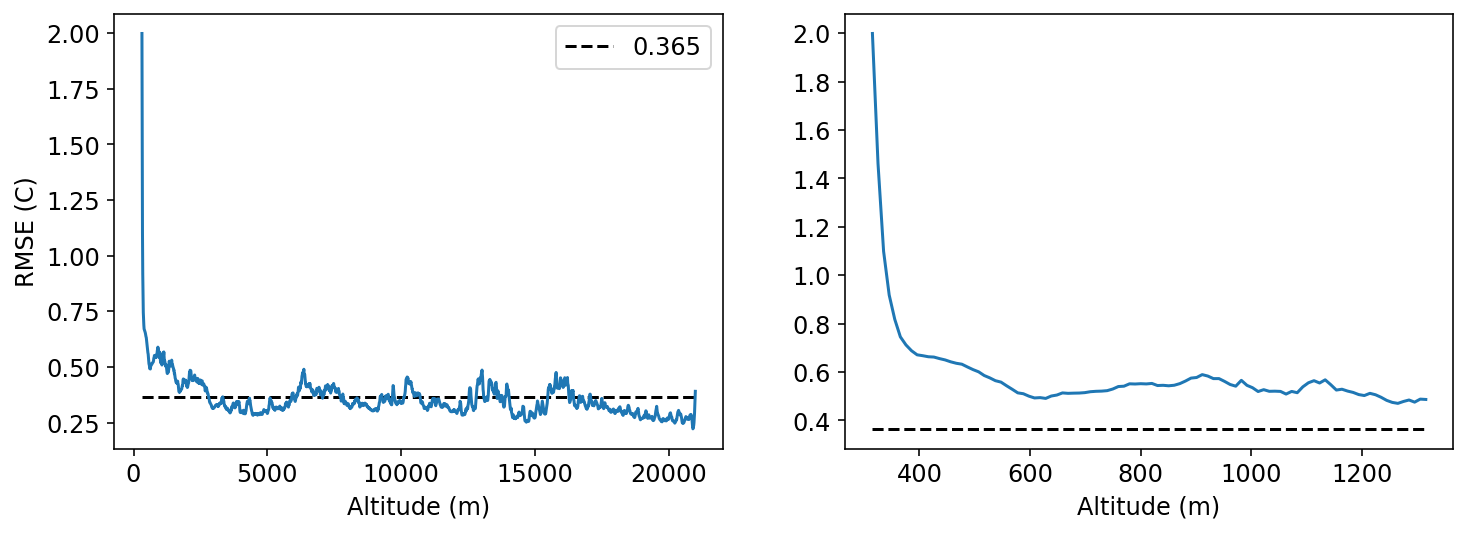

In [143]:
plot_altitude_rmse(nnet, Xtest, Ttest)

In [169]:
epochs = 25
batch_size = 32
rho = 0.001
activation = 'relu'
method = 'adam'
units = [4, 4, 8, 8]
ker_str = [(10, 1)]*4
hidden_dims_l = [32, 128, 512, 1024]

total_rmse_l = []

for hidden_dims in hidden_dims_l:
    
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], units, ker_str,
                                       Ttrain.shape[1], activation=activation,
                                       n_hidden_dims=hidden_dims, seed=1234)
    
    nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method, verbose=False, 
               learning_rate=rho, validation=[Xtest, Ttest])

    total_rmse_l.append(ml.rmse(nnet.use(Xtest), Ttest))

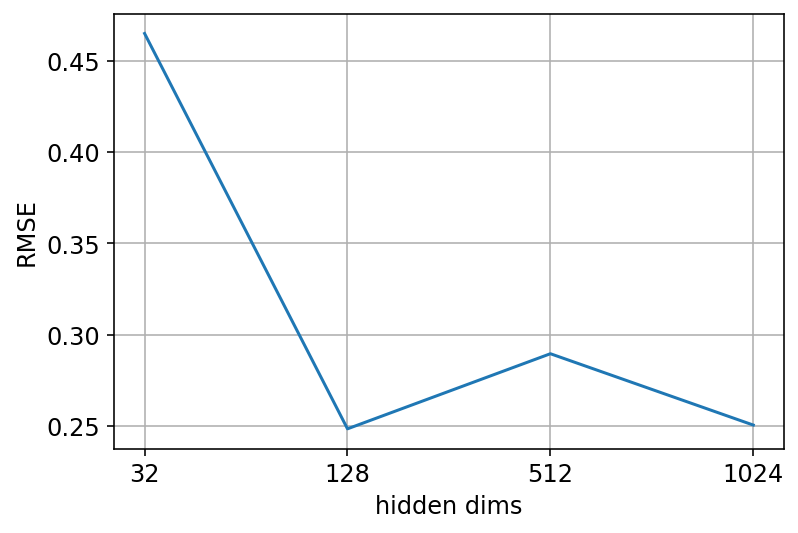

In [170]:
fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(total_rmse_l)

ax.set_xticks(range(len(hidden_dims_l)))
ax.set_xticklabels(hidden_dims_l)

ax.set_xlabel('hidden dims'), ax.set_ylabel('RMSE')
ax.grid(True)
plt.show();

### Surface Error Profiles

1. read in valid_profile_files
2. partition data without shuffeling
3. train nnet above
4. run cells below

In [10]:
rmse_l = np.zeros(Ttest.shape)

for i in range(len(Xtest)):
    Y = nnet.use(Xtest[i:i+1, ...])
    T = Ttest[i:i+1]
    rmse_l[i] = np.sqrt((np.mean((Y - T)**2, axis=0)))

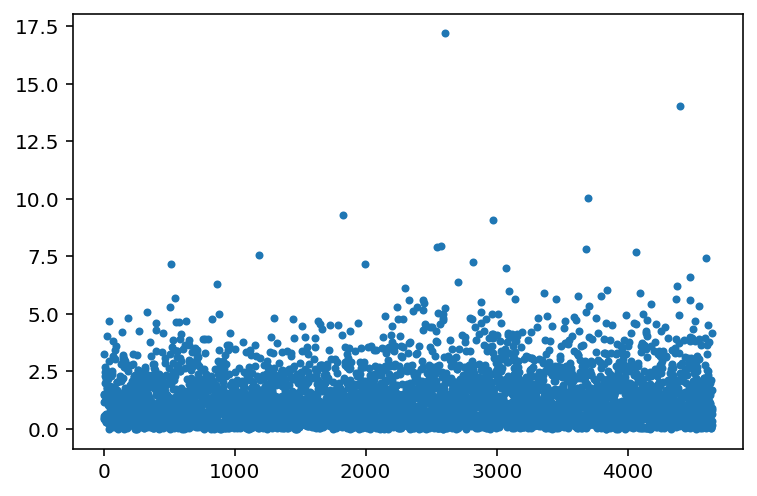

In [11]:
plt.plot(rmse_l[:, 0], '.');

#### Highest Error Profiles

In [12]:
surface_err = rmse_l[:, 0].flatten()

In [15]:
n_highest = 10
high_ind = np.argpartition(surface_err, -n_highest)[-n_highest:]
highest_err_ind = high_ind[np.argsort(surface_err[high_ind])][::-1]
highest_err_files = valid_profile_files[Xtrain.shape[0] + highest_err_ind]
highest_err_files

array(['/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2006/sgpsondewnpnC1.b1.20060906.173000.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2011/sgpsondewnpnC1.b1.20110129.052900.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2011/sgpsondewnpnC1.b1.20110221.051600.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2001/sgpsondewnpnC1.b1.20011001.052700.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2006/sgpsondewnpnC1.b1.20060107.172700.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2006/sgpsondewnpnC1.b1.20060331.053200.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2006/sgpsondewnpnC1.b1.20060420.112700.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2011/sgpsondewnpnC1.b1.20110214.052800.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2011/sgpsondewnpnC1.b1.20110211.173200.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm

7.5447989403796925


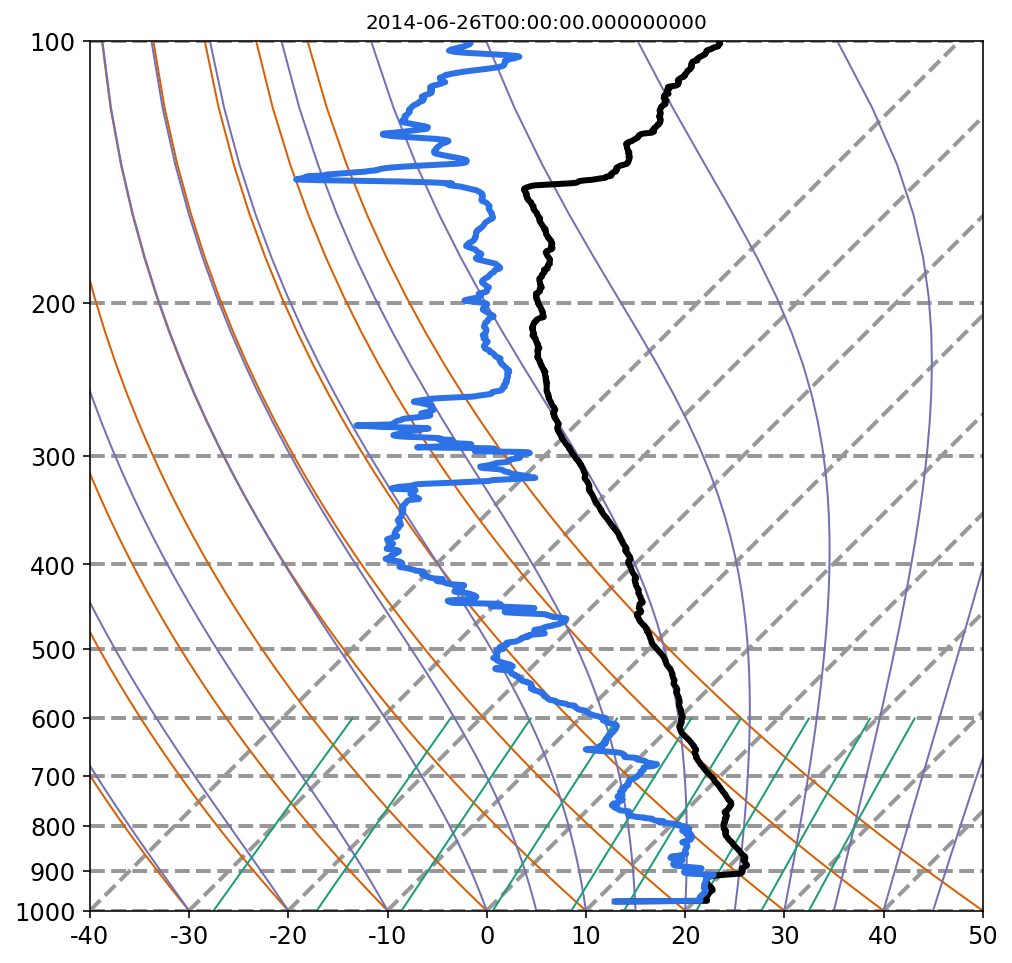

In [78]:
# Xtest[highest_err_ind[nth], :, PRESSURE] ... to use test values

nth = 9
print(surface_err[highest_err_ind[nth]])

xar = xr.open_dataset(highest_err_files[nth])

sounding_dict_for_metpy = dict()
sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = xar.pres.values
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = xar.tdry.values
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = xar.dp.values

title = highest_err_files[nth].split('/')

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy, title_string=xar.base_time.values)#, file_name='../' + str(nth) + '.' + title[-2] + '.' + title[-1][:-4] + '.jpg')
plt.show(); xar.close()

#### Lowest Error Profiles

In [29]:
n_lowest = 10
low_ind = np.argpartition(surface_err, n_lowest)[:n_lowest]
lowest_err_ind = low_ind[np.argsort(surface_err[low_ind])]
lowest_err_files = valid_profile_files[Xtrain.shape[0] + lowest_err_ind]
lowest_err_files

array(['/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2001/sgpsondewnpnC1.b1.20011024.233600.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2014/sgpsondewnpnC1.b1.20140820.112900.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2014/sgpsondewnpnC1.b1.20140421.112700.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2001/sgpsondewnpnC1.b1.20010620.210600.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2014/sgpsondewnpnC1.b1.20140507.234000.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2014/sgpsondewnpnC1.b1.20141001.052600.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2014/sgpsondewnpnC1.b1.20140726.053000.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2011/sgpsondewnpnC1.b1.20110911.232900.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm-sgp/2001/sgpsondewnpnC1.b1.20010722.052300.cdf',
       '/s/chopin/l/grad/stock/data/soundings/raobs/arm

0.002469782455591485


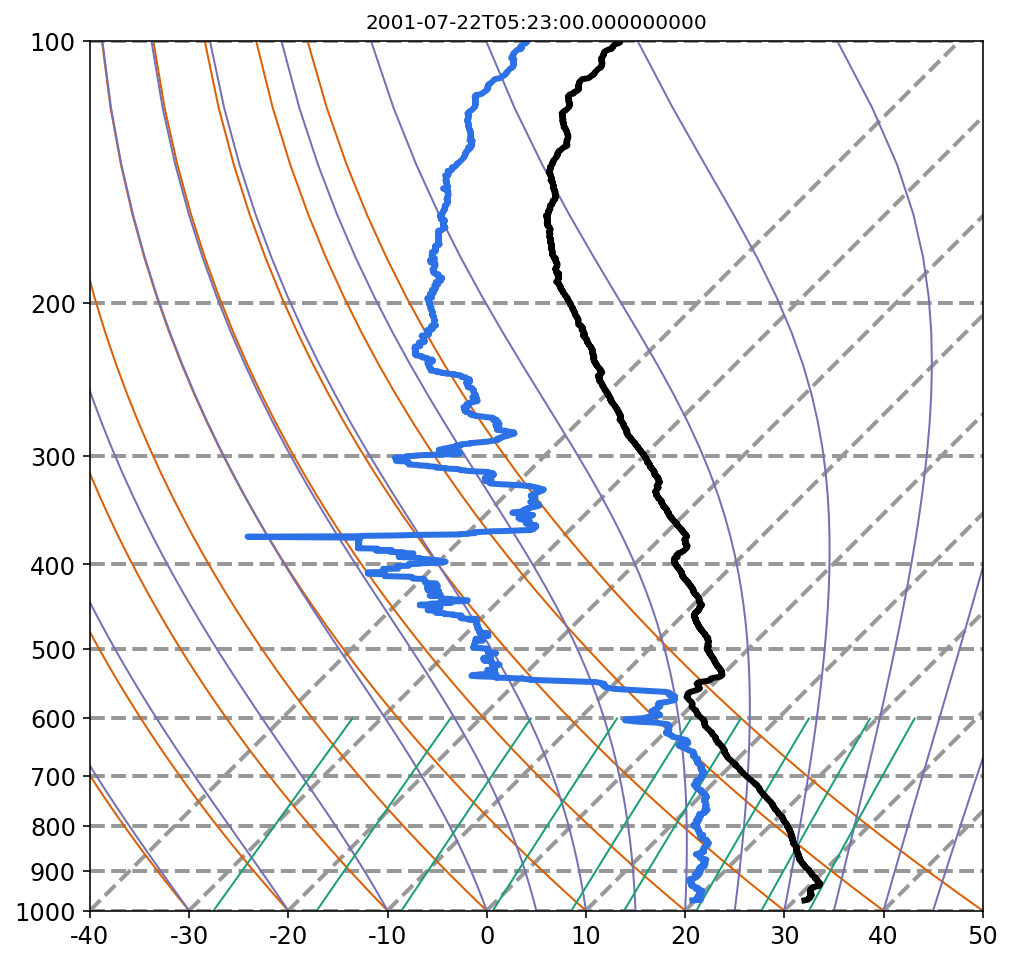

In [37]:
# Xtest[lowest_err_ind[nth], :, PRESSURE] ... to use test values

nth = 8
print(surface_err[lowest_err_ind[nth]])
xar = xr.open_dataset(lowest_err_files[nth])

sounding_dict_for_metpy = dict()
sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = xar.pres.values
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = xar.tdry.values
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = xar.dp.values

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy, title_string=xar.base_time.values)
plt.show(); xar.close()

### Error Distribution by Month

In [123]:
ind = Xtrain.shape[0]
months = np.zeros(len(Xtest))
# start at offset of Xtest
for i in range(len(Xtest)):
    f = valid_profile_files[ind + i]
    xar = xr.open_dataset(f)
    months[i] = datetime.datetime.strptime(str(xar.base_time.values)[:-3], '%Y-%m-%dT%H:%M:%S.%f').month
    xar.close()

In [357]:
total_rmse_l = np.zeros(len(Ttest))

for i in range(len(Xtest)):
    Y = nnet.use(Xtest[i:i+1, ...])
    T = Ttest[i:i+1]
    total_rmse_l[i] = ml.rmse(Y, T)

In [369]:
monthly_surface_err = []
monthly_total_err = []

for month in np.unique(months):
    monthly_surface_err.append(surface_err[months == month])
    monthly_total_err.append(total_rmse_l[months == month])

In [370]:
ind = np.abs(total_rmse_l - total_rmse_l.max()).argmin()
print(f'outlier at index: {ind} has error of: {total_rmse_l[ind]}') 

outlier at index: 1382 has error of: 1.0277017936904234


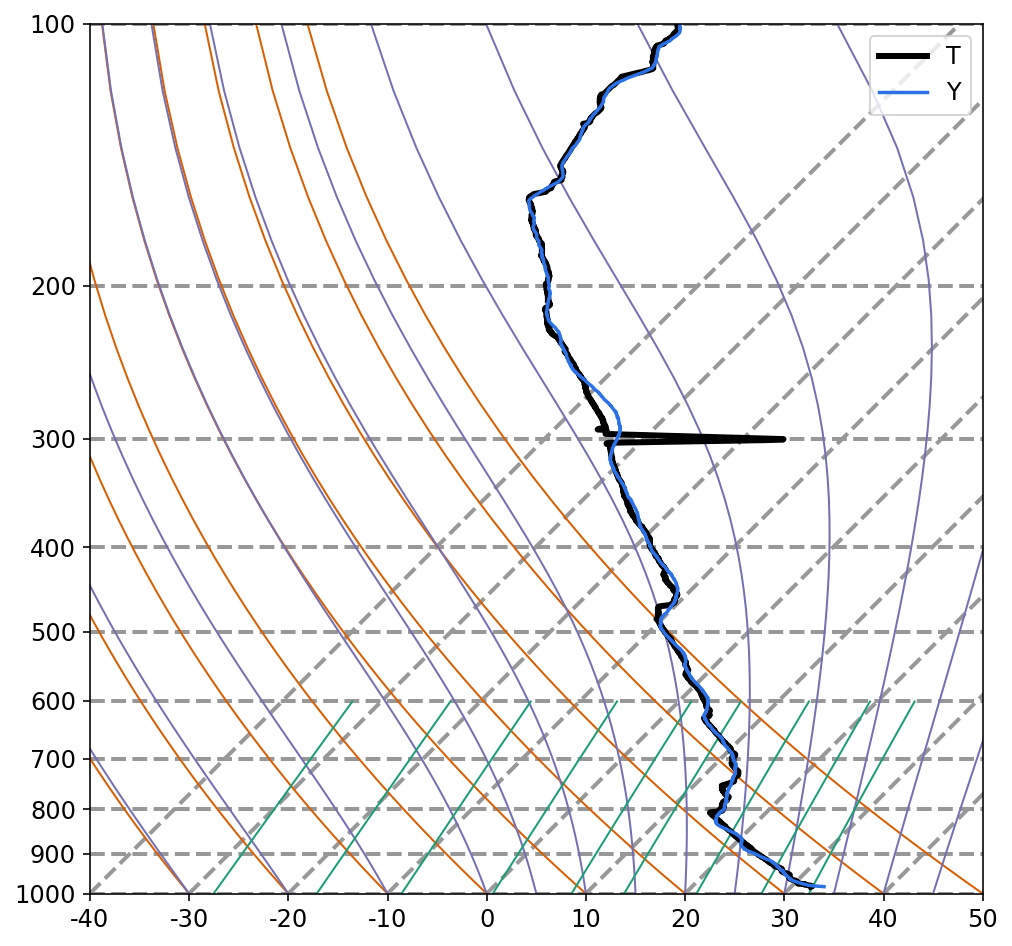

In [355]:
plot_results(nnet, Xtest, Ttest, 1382, loss=False) #11, 17

In [371]:
# remove outlier
monthly_total_err[6] = np.delete(monthly_total_err[6], 
                                 np.abs(monthly_total_err[6] - monthly_total_err[6].max()).argmin())

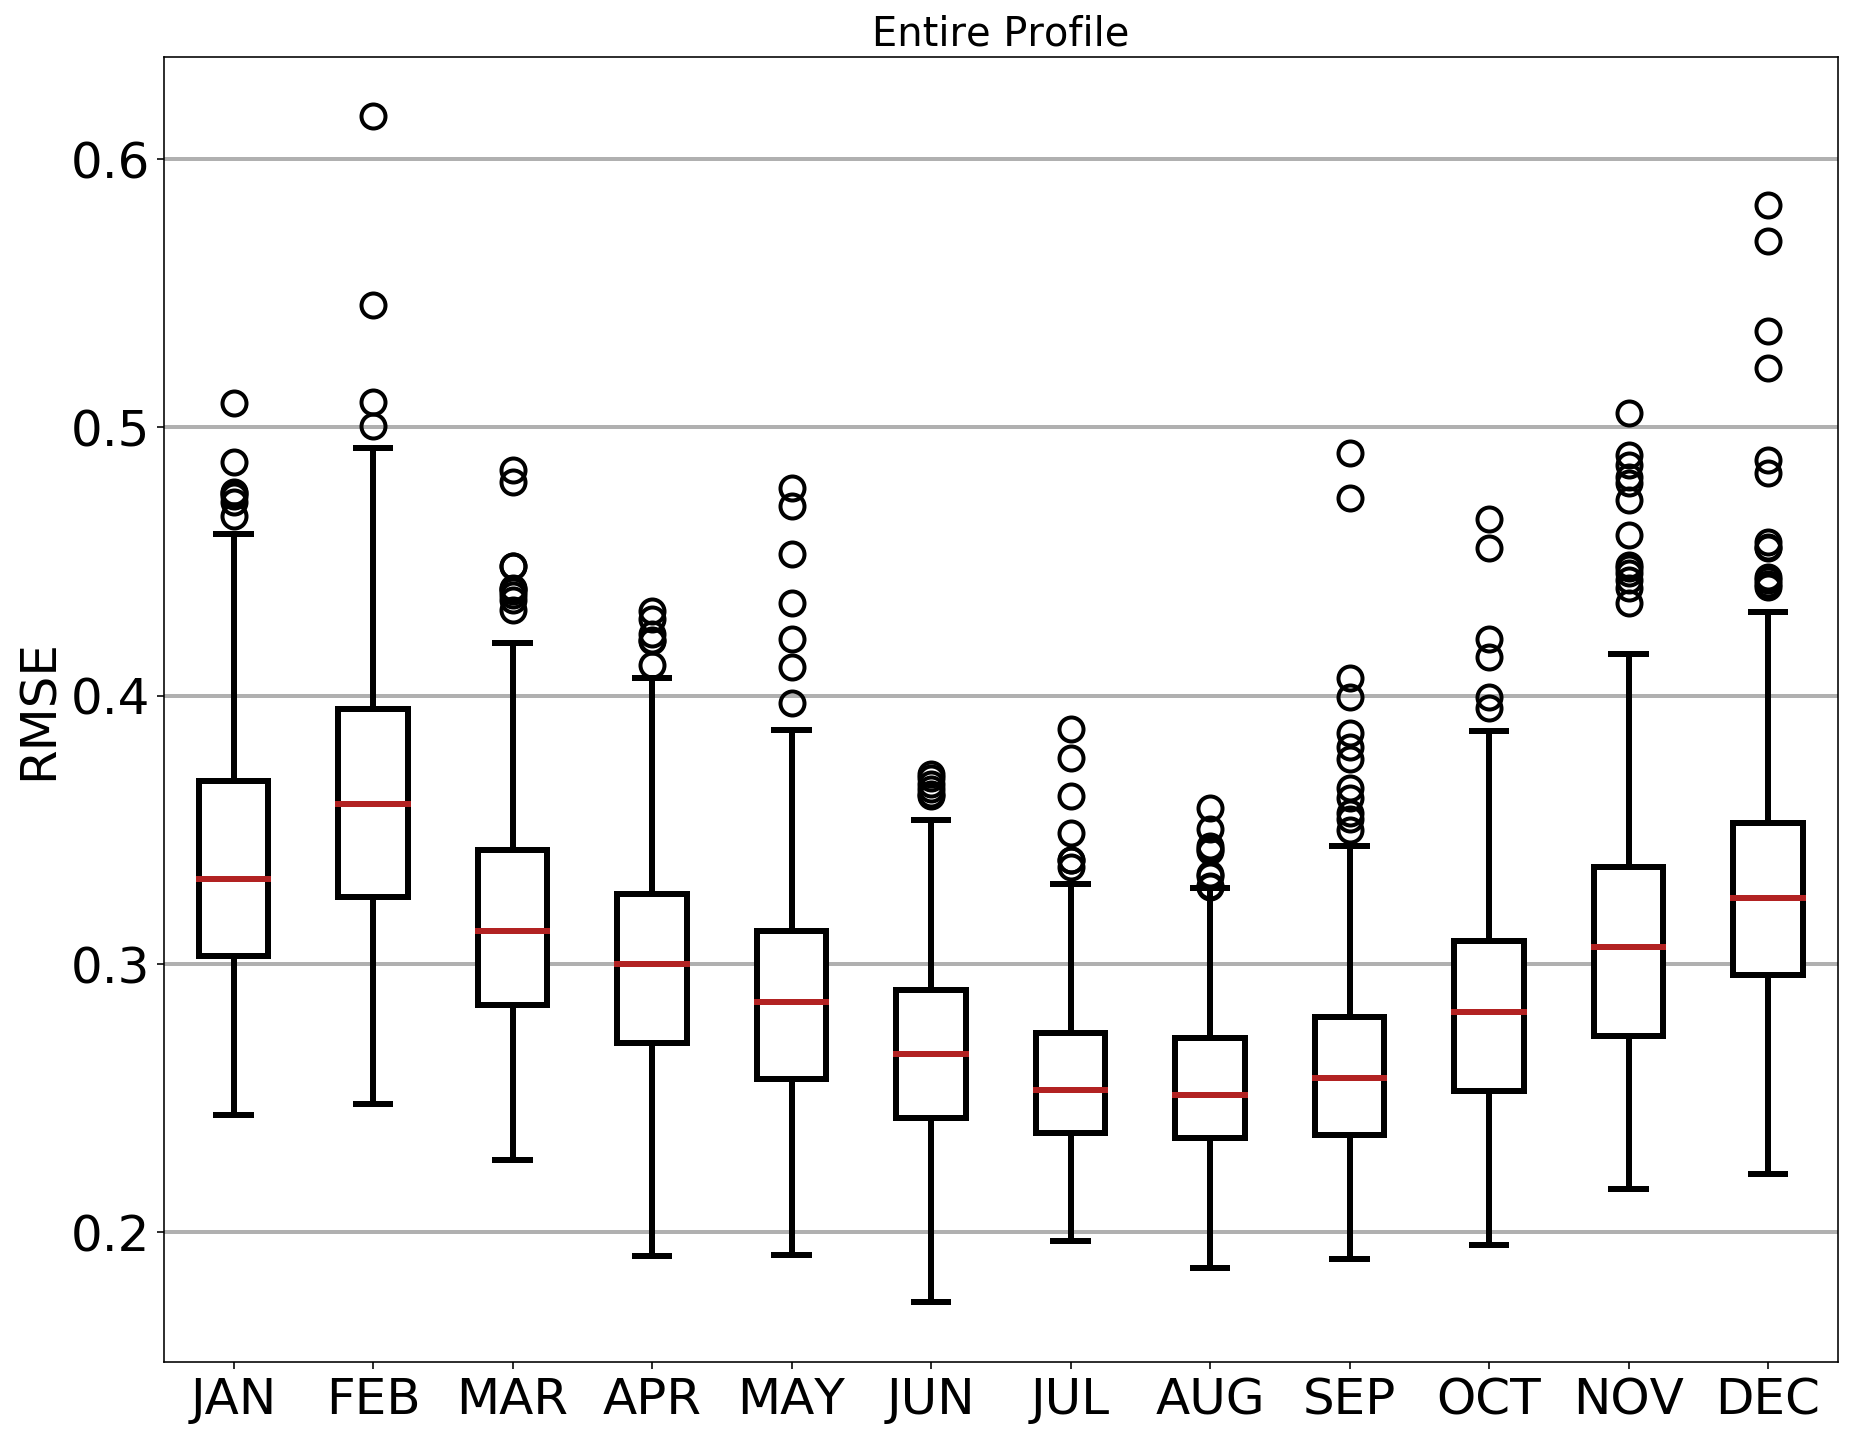

In [380]:
radiosonde_plotting.plot_monthly_error(monthly_total_err, months, 'Entire Profile', file_name='../monthly_error');

---
# CAE Improvements

&emsp; [ [**1.**](#1.-Intropolation) ] Interpolate high pressure values - increase precision at lower altitudes  
&emsp; [ [**2.**](#2.-Weighted-Loss) ] Apply more weight to high pressure values - modify loss function  
&emsp; [ [**3.**](#3.-RTMA-Surface) ] Ground surface level measurements - include RTMA data to improve on surface RAOB data  
&emsp; [ [**4.**](#4.-Independant-Model-Levels) ] Evaluate models that are trained at different levels - can the surface be modeled correctly without interference of higher altitudes

## 1. Intropolation

### Increased Surface Percision 

In [205]:
lower_pres = 700
alts = np.zeros(len(profiles))

for i in range(len(profiles)):
    profile = profiles[i]
    alts[i] = profile[:, ALTITUDE][(np.abs(profile[:, PRESSURE] - lower_pres)).argmin()]    

In [206]:
print(f'{alts.shape}, mean: {alts.mean():.2f}, std: {alts.std():.2f}, max: {alts.max():.2f}, min: {alts.min():.2f}')

(23237,), mean: 3113.16, std: 74.19, max: 3366.00, min: 1835.80


In [251]:
alt_s = profiles[0][0, ALTITUDE] # 315
alt_svn = alts.mean()
altitude_svn = np.linspace(alt_s, alt_svn, SONDE_PROFILE_DIMS // 2, endpoint=False)
altitude_top = np.linspace(alt_svn, alt_el, SONDE_PROFILE_DIMS // 2)
altitude_intervals = np.concatenate((altitude_svn, altitude_top))

In [218]:
interpolated_profiles = np.zeros((len(profiles), SONDE_PROFILE_DIMS, 4))
for i in range(len(profiles)):
    profile = profiles[i]
    # remove duplicate values at surface level 
    alt_s = profile[0, ALTITUDE]
    start_indx = 0
    for j in range(1, len(profile[:, ALTITUDE])):
        if profile[j, ALTITUDE] == alt_s:
            start_indx = j
        else:
            break
            
    p_n = interpolate_to_height_intervals(profile[start_indx:, ALTITUDE], profile[start_indx:, PRESSURE], altitude_intervals)
    t_n = interpolate_to_height_intervals(profile[start_indx:, ALTITUDE], profile[start_indx:, TEMPERATURE], altitude_intervals)
    td_n = interpolate_to_height_intervals(profile[start_indx:, ALTITUDE], profile[start_indx:, DEWPOINT], altitude_intervals)
    
    interpolated_profiles[i] = np.concatenate(([p_n], [t_n], [td_n], [altitude_intervals])).T

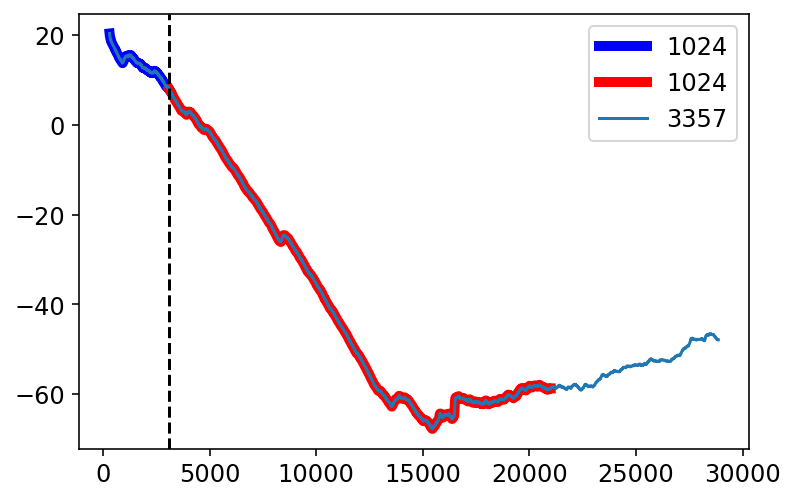

In [249]:
i = 2
plt.plot(interpolated_profiles[i, :SONDE_PROFILE_DIMS // 2, ALTITUDE],
         interpolated_profiles[i, :SONDE_PROFILE_DIMS // 2, TEMPERATURE], lw=5,
         label=str(len(interpolated_profiles[i, :SONDE_PROFILE_DIMS // 2:, ALTITUDE])), color='b')
plt.plot(interpolated_profiles[i, SONDE_PROFILE_DIMS // 2:, ALTITUDE],
         interpolated_profiles[i, SONDE_PROFILE_DIMS // 2:, TEMPERATURE], lw=5,
         label=str(len(interpolated_profiles[i, SONDE_PROFILE_DIMS // 2::, ALTITUDE])), color='r')
plt.plot(profiles[i][:, ALTITUDE], profiles[i][:, TEMPERATURE],
         label=str(len(profiles[i][:, ALTITUDE])))
plt.axvline(alt_svn, ls='--', color='k')
plt.legend();

In [230]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(interpolated_profiles, interpolated_profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((18590, 2048, 3), (18590, 2048), (4647, 2048, 3), (4647, 2048))

In [253]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(10, 1)]*4,
                                   Ttrain.shape[1], activation='relu',
                                   n_hidden_dims=512, seed=1234)
# nnet.model.summary()
nnet.train(Xtrain, Ttrain, 20, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.11648
epoch: 5, loss: 0.00792
epoch: 10, loss: 0.00542
epoch: 15, loss: 0.00465
epoch: 19, loss: 0.00421
finished!


ConvolutionalAutoEncoder((2048, 3), [4, 4, 8, 8], [(10, 1), (10, 1), (10, 1), (10, 1)], 2048)
  Final objective value is 0.00421 in 334.3926 seconds.

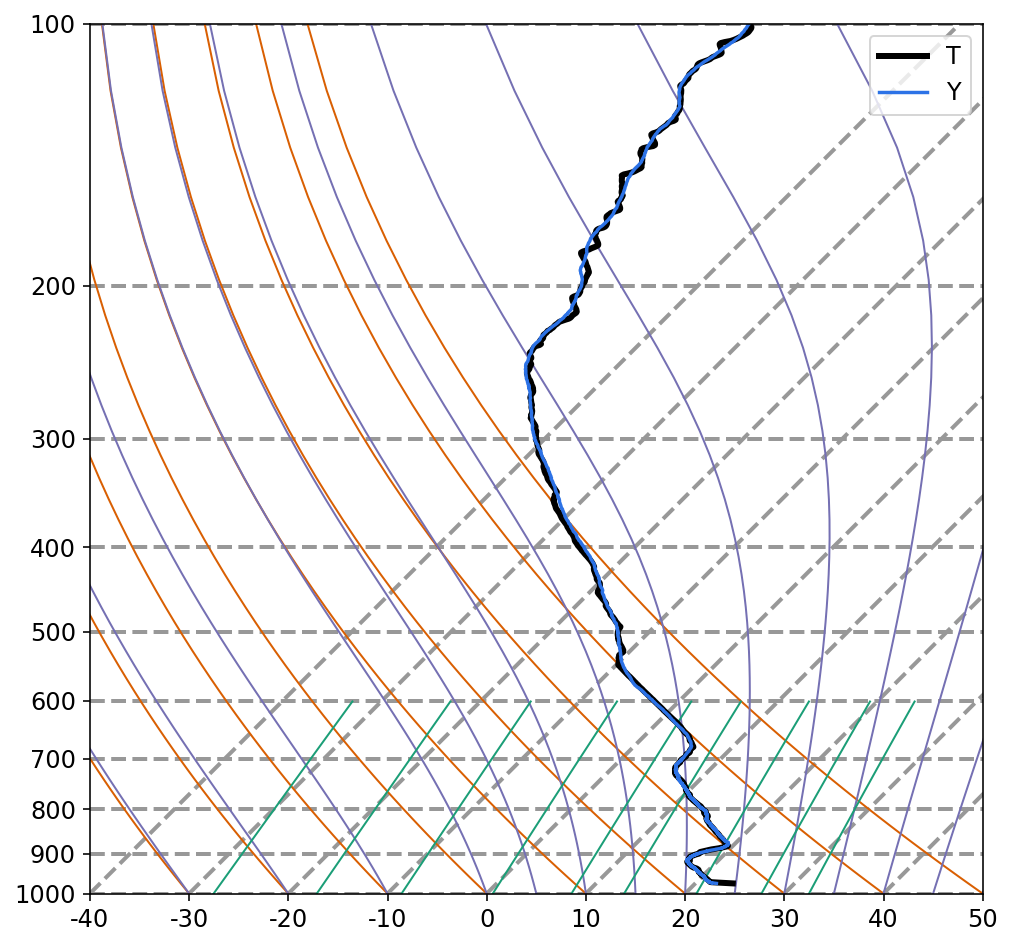

In [257]:
plot_results(nnet, Xtest, Ttest, 25, loss=False) #25

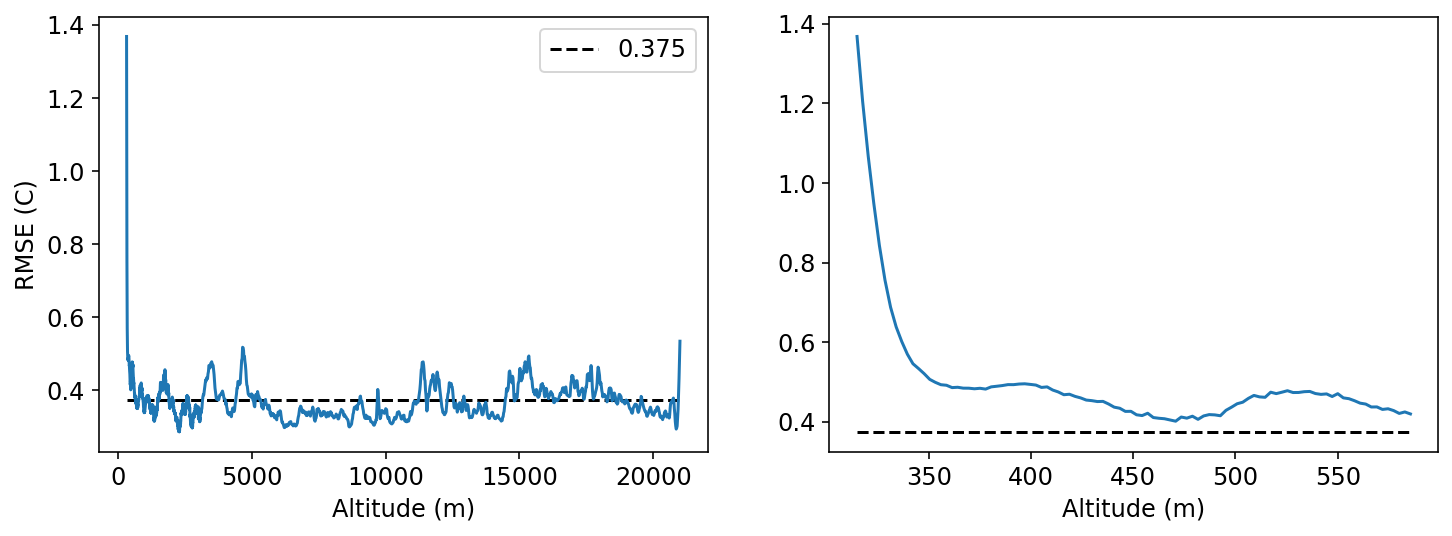

In [255]:
plot_altitude_rmse(nnet, Xtest, Ttest)

### Increased Overall Percision

In [258]:
SONDE_PROFILE_DIMS = 4096
alt_s = profiles[0][0, ALTITUDE] # 315
altitude_intervals = np.linspace(alt_s, alt_el, SONDE_PROFILE_DIMS)

In [259]:
interpolated_profiles = np.zeros((len(profiles), SONDE_PROFILE_DIMS, 4))
for i in range(len(profiles)):
    
    # remove duplicate values at surface level 
    alt_s = profiles[i][0, ALTITUDE]
    start_indx = 0
    for j in range(1, len(profiles[i][:, ALTITUDE])):
        if profiles[i][j, ALTITUDE] == alt_s:
            start_indx = j
        else:
            break
            
    p_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, PRESSURE], altitude_intervals)
    t_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, TEMPERATURE], altitude_intervals)
    td_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, DEWPOINT], altitude_intervals)
    
    interpolated_profiles[i] = np.concatenate(([p_n], [t_n], [td_n], [altitude_intervals])).T

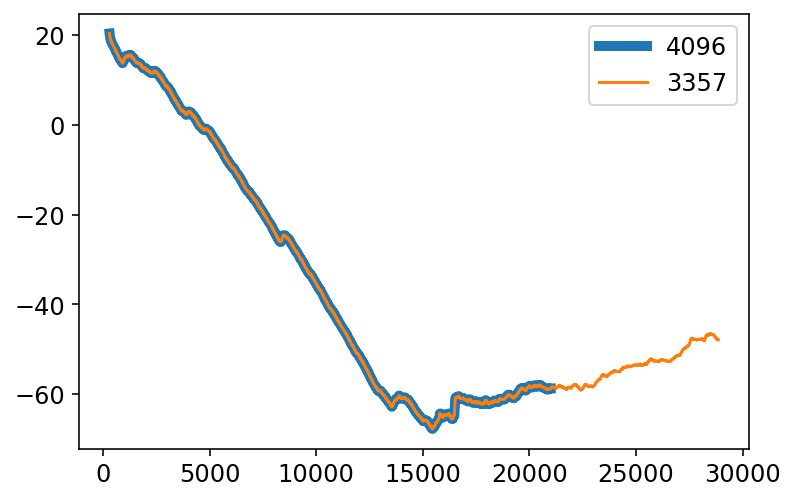

In [260]:
i = 2
plt.plot(interpolated_profiles[i, :, ALTITUDE],
         interpolated_profiles[i, :, TEMPERATURE], lw=5,
         label=str(len(interpolated_profiles[i, :, ALTITUDE])))
plt.plot(profiles[i][:, ALTITUDE], profiles[i][:, TEMPERATURE],
         label=str(len(profiles[i][:, ALTITUDE])))
plt.legend();

In [261]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(interpolated_profiles, interpolated_profiles, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((18590, 4096, 3), (18590, 4096), (4647, 4096, 3), (4647, 4096))

In [262]:
nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(10, 1)]*4,
                                   Ttrain.shape[1], activation='relu',
                                   n_hidden_dims=128, seed=1234)
# nnet.model.summary()
nnet.train(Xtrain, Ttrain, 20, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.12975
epoch: 5, loss: 0.00693
epoch: 10, loss: 0.00411
epoch: 15, loss: 0.00333
epoch: 19, loss: 0.00314
finished!


ConvolutionalAutoEncoder((4096, 3), [4, 4, 8, 8], [(10, 1), (10, 1), (10, 1), (10, 1)], 4096)
  Final objective value is 0.00314 in 767.1884 seconds.

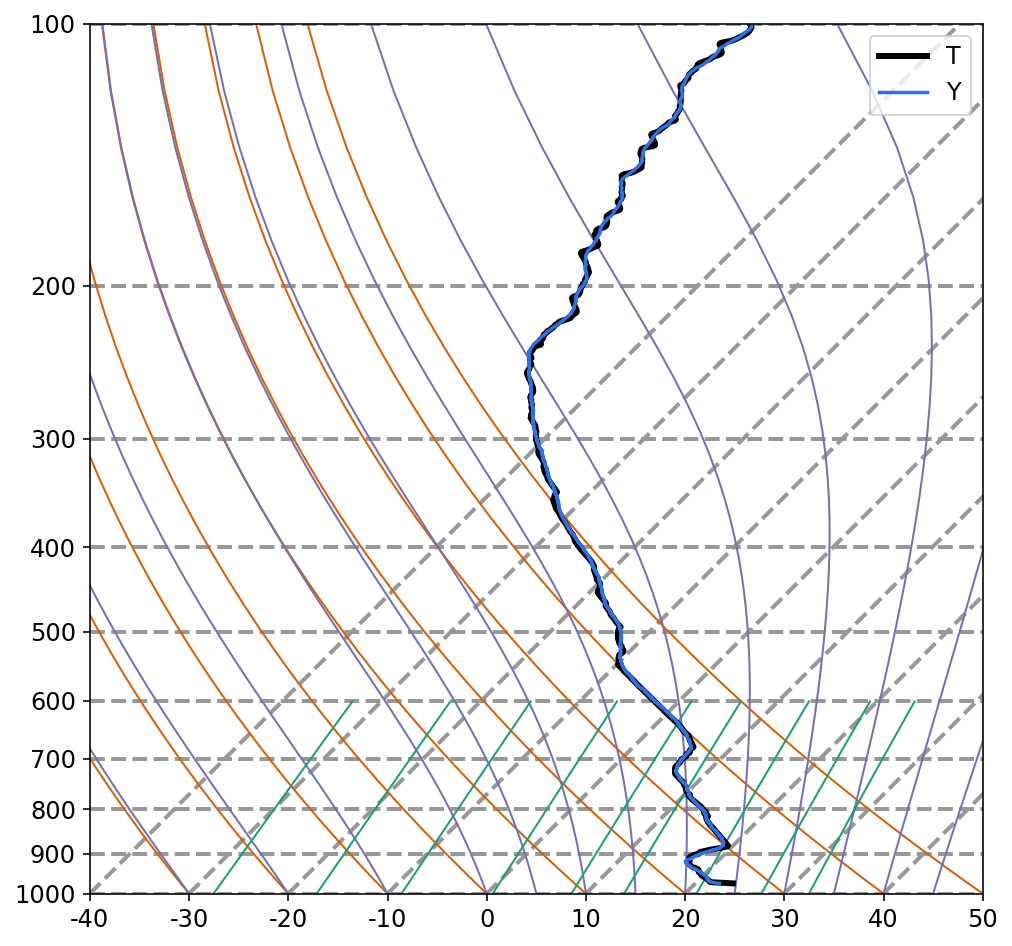

In [263]:
plot_results(nnet, Xtest, Ttest, 25, loss=False) #25

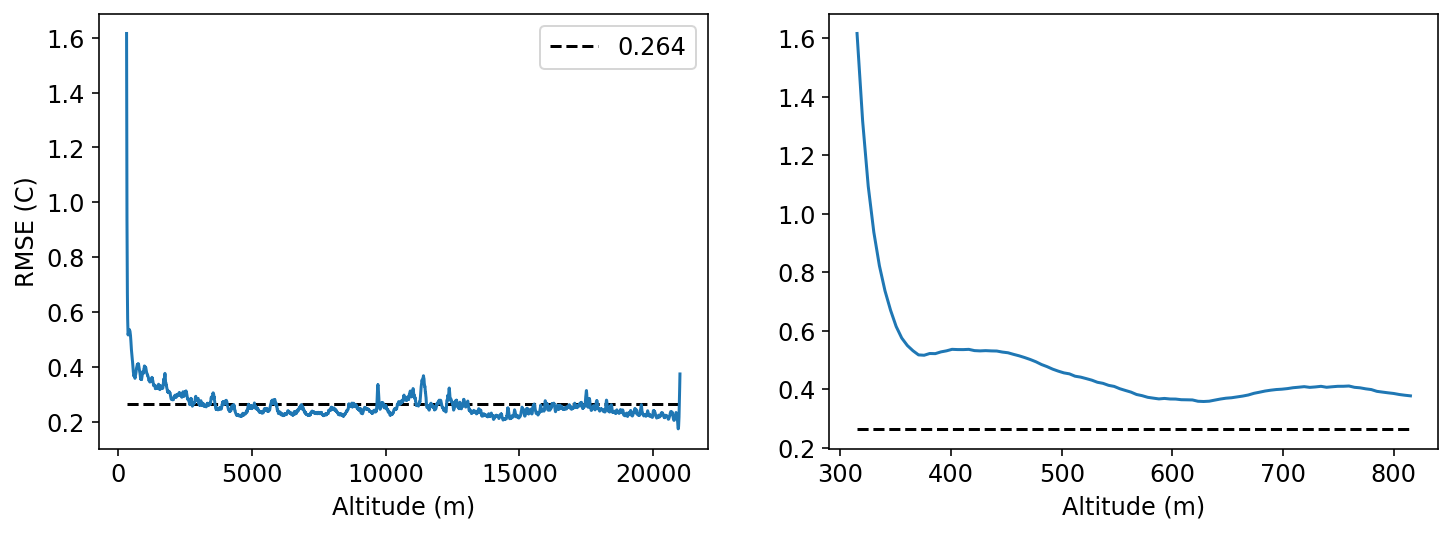

In [264]:
plot_altitude_rmse(nnet, Xtest, Ttest)

## 2. Weighted Loss

In [119]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

$\text{E} = \frac{1}{N} \sum^N_{n = 1} (Y_n - T_n)^2 (m e^{-\lambda t} + 1) : m = \text{initial value}, \lambda = \text{decay constant}$

In [120]:
def weighted_mean_squared_error(y_true, y_pred, scale, lmda):
    """exponential decay weighted MSE"""
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.squared_difference(y_pred, y_true)

    x = np.arange(diff.shape[1])
    y = lambda x: scale * np.exp(-lmda * x) + 1
    diff *= y(x)

    return K.mean(diff, axis=-1)

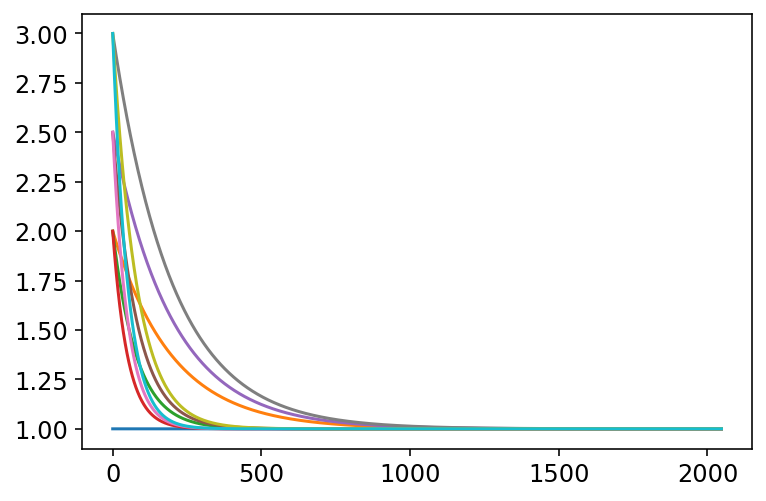

In [117]:
x = np.arange(Xtest.shape[1])

scales = np.linspace(1, 2, 3)
lmdas = np.linspace(0.005, 0.02, 3)

product = list(itertools.product(scales, lmdas))
product.insert(0, (0., 0.))

for scale, lmda in product:
    y = lambda x: scale * np.exp(-lmda * x) + 1
    plt.plot(y(x));

In [121]:
loss_l = []
rmse_l = []
total_rmse_l = []

f = FloatProgress(min=0, max=(len(product)))
display(f)

for scale, lmda in product:
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(10, 1)]*4,
                                       Ttrain.shape[1], activation='relu',
                                       n_hidden_dims=128, seed=1234)

    nnet.train(Xtrain, Ttrain, 20, 32, method='adam', verbose=False, 
               learning_rate=0.001, validation=[Xtest, Ttest], 
               loss_f=[lambda y_true,y_pred: weighted_mean_squared_error(y_true, y_pred, 
                                                                         scale=scale, lmda=lmda)])
    
    loss_l.append(nnet.history['val_loss'])
    
    Y = nnet.use(Xtest)
    rmse_l.append(np.sqrt((np.mean((Y - Ttest)**2, axis=0))))
    total_rmse_l.append(ml.rmse(Y, Ttest))
    
    f.value += 1

FloatProgress(value=0.0, max=10.0)

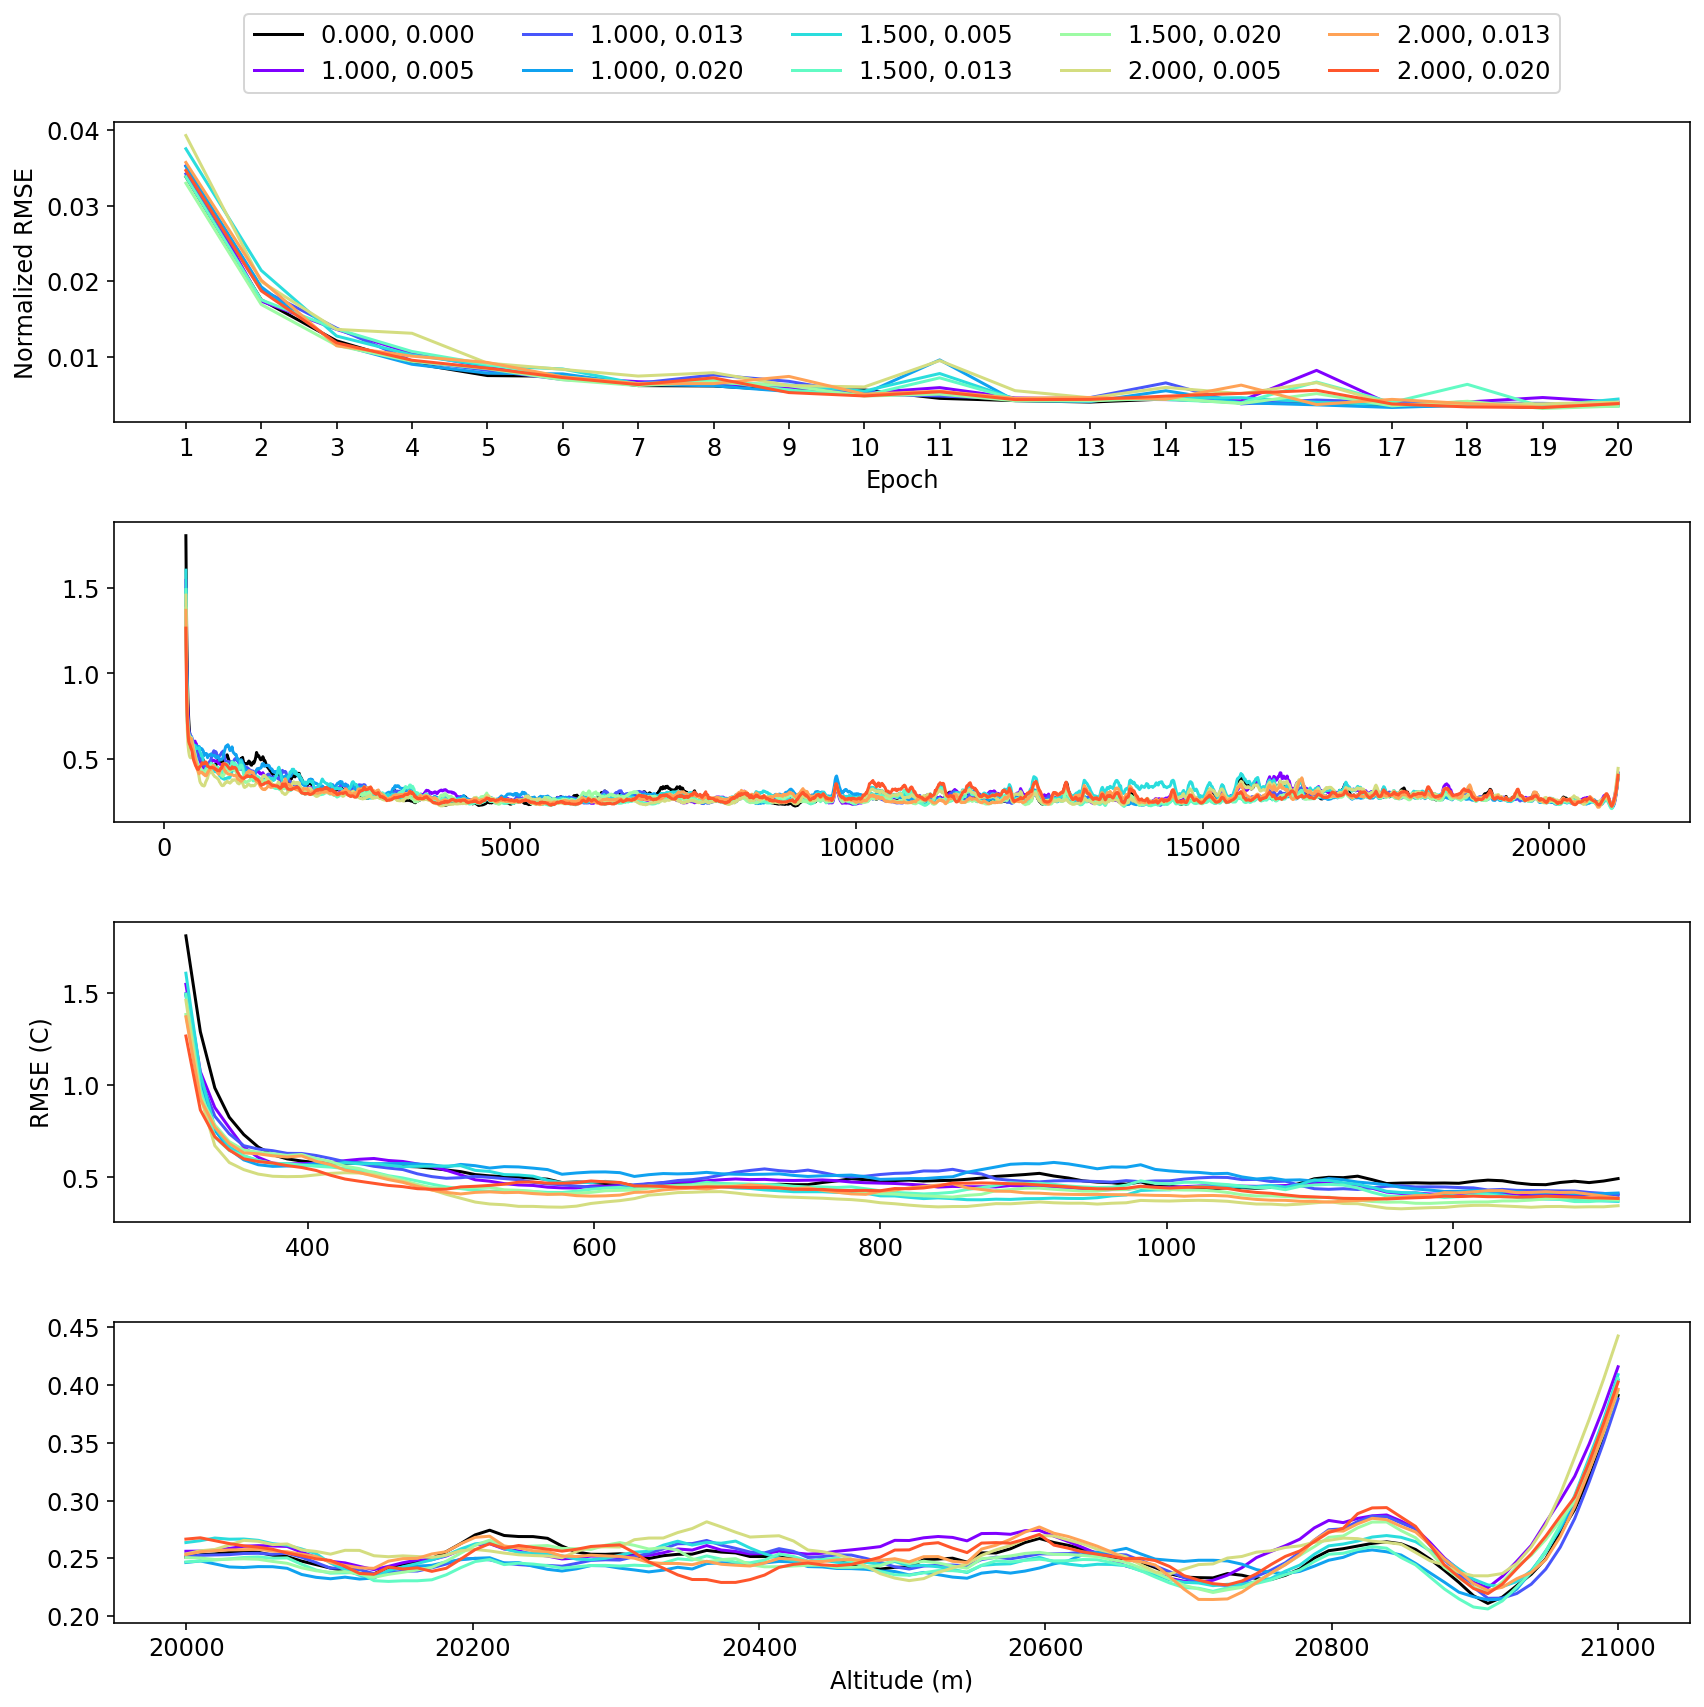

In [122]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
axs = axs.ravel()

color=iter(plt.cm.rainbow(np.linspace(0,1,len(product))))
alt_s = interpolated_profiles[0, 0, ALTITUDE]
altitude_intervals = np.linspace(alt_s, alt_el, SONDE_PROFILE_DIMS)
altitude_window = 100

i = 0
for scale, lmda in product:
    c = next(color) if i > 0 else 'k'
    axs[0].plot(loss_l[i], label=f'{scale:.3f}, {lmda:.3f}', color=c)
    axs[1].plot(altitude_intervals, rmse_l[i], color=c)
    axs[2].plot(altitude_intervals[:altitude_window], rmse_l[i][:altitude_window], color=c)
    axs[3].plot(altitude_intervals[-altitude_window:], rmse_l[i][-altitude_window:], color=c)
    i += 1

axs[0].set_xticks(range(len(loss_l[0])))
axs[0].set_xticklabels(range(1, len(loss_l[0]) + 1))
axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Normalized RMSE')
axs[3].set_xlabel('Altitude (m)'); axs[2].set_ylabel('RMSE (C)');

axs.flatten()[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=5)
fig.tight_layout();

In [123]:
results = []
i = 0
for scale, lmda in product:
    results.append({'scale': f'{scale:.2f}', 'lambda': f'{lmda:.2f}',
                    'min_loss': np.min(loss_l[i]), 'rmse': total_rmse_l[i]})
    i += 1
df = pd.DataFrame(results)
df

,scale,lambda,min_loss,rmse
0,0.00,0.00,0.003339,0.300873
1,1.00,0.01,0.003670,0.298901
2,1.00,0.01,0.003673,0.294454
3,1.00,0.02,0.003332,0.298154
4,1.50,0.01,0.003502,0.309208
5,1.50,0.01,0.003419,0.280774
6,1.50,0.02,0.003199,0.282219
7,2.00,0.01,0.003750,0.286432
8,2.00,0.01,0.003381,0.290072
9,2.00,0.02,0.003317,0.291972


In [124]:
df.sort_values('rmse')

,scale,lambda,min_loss,rmse
5,1.50,0.01,0.003419,0.280774
6,1.50,0.02,0.003199,0.282219
7,2.00,0.01,0.003750,0.286432
8,2.00,0.01,0.003381,0.290072
9,2.00,0.02,0.003317,0.291972
2,1.00,0.01,0.003673,0.294454
3,1.00,0.02,0.003332,0.298154
1,1.00,0.01,0.003670,0.298901
0,0.00,0.00,0.003339,0.300873
4,1.50,0.01,0.003502,0.309208


## 3. RTMA Surface

## 4. Independant Model Levels

In [11]:
altitude_intervals.shape, interpolated_profiles.shape

((2048,), (23237, 2048, 4))

In [178]:
steps = 4
step_size = interpolated_profiles.shape[1] // steps
start = 0

loss_l = []
rmse_l = []
total_rmse_l = []

f = FloatProgress(min=0, max=(steps))
display(f)

for i in range(steps):
    Xtrain, Ttrain, Xtest, Ttest = ml.partition(interpolated_profiles, 
                                                interpolated_profiles, (0.8,0.2), shuffle=False)
    
    input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

    Xtrain = Xtrain[:, start:start+step_size, input_dims]
    Ttrain = Ttrain[:, start:start+step_size, TEMPERATURE]

    Xtest = Xtest[:, start:start+step_size, input_dims]
    Ttest = Ttest[:, start:start+step_size, TEMPERATURE]
    
    nnet = nn.ConvolutionalAutoEncoder(Xtrain.shape[1:], [4, 4, 8, 8], [(10, 1)]*4,
                                       Ttrain.shape[1], activation='relu',
                                       n_hidden_dims=128, seed=1234)
    nnet.train(Xtrain, Ttrain, 20, 32, method='adam', verbose=False, 
               learning_rate=0.001, validation=[Xtest, Ttest])
    
    loss_l.append(nnet.history['val_loss'])
    
    Y = nnet.use(Xtest)
    rmse_l.append(np.sqrt((np.mean((Y - Ttest)**2, axis=0))))
    total_rmse_l.append(ml.rmse(Y, Ttest))
    
    start += step_size
    f.value += 1

FloatProgress(value=0.0, max=4.0)

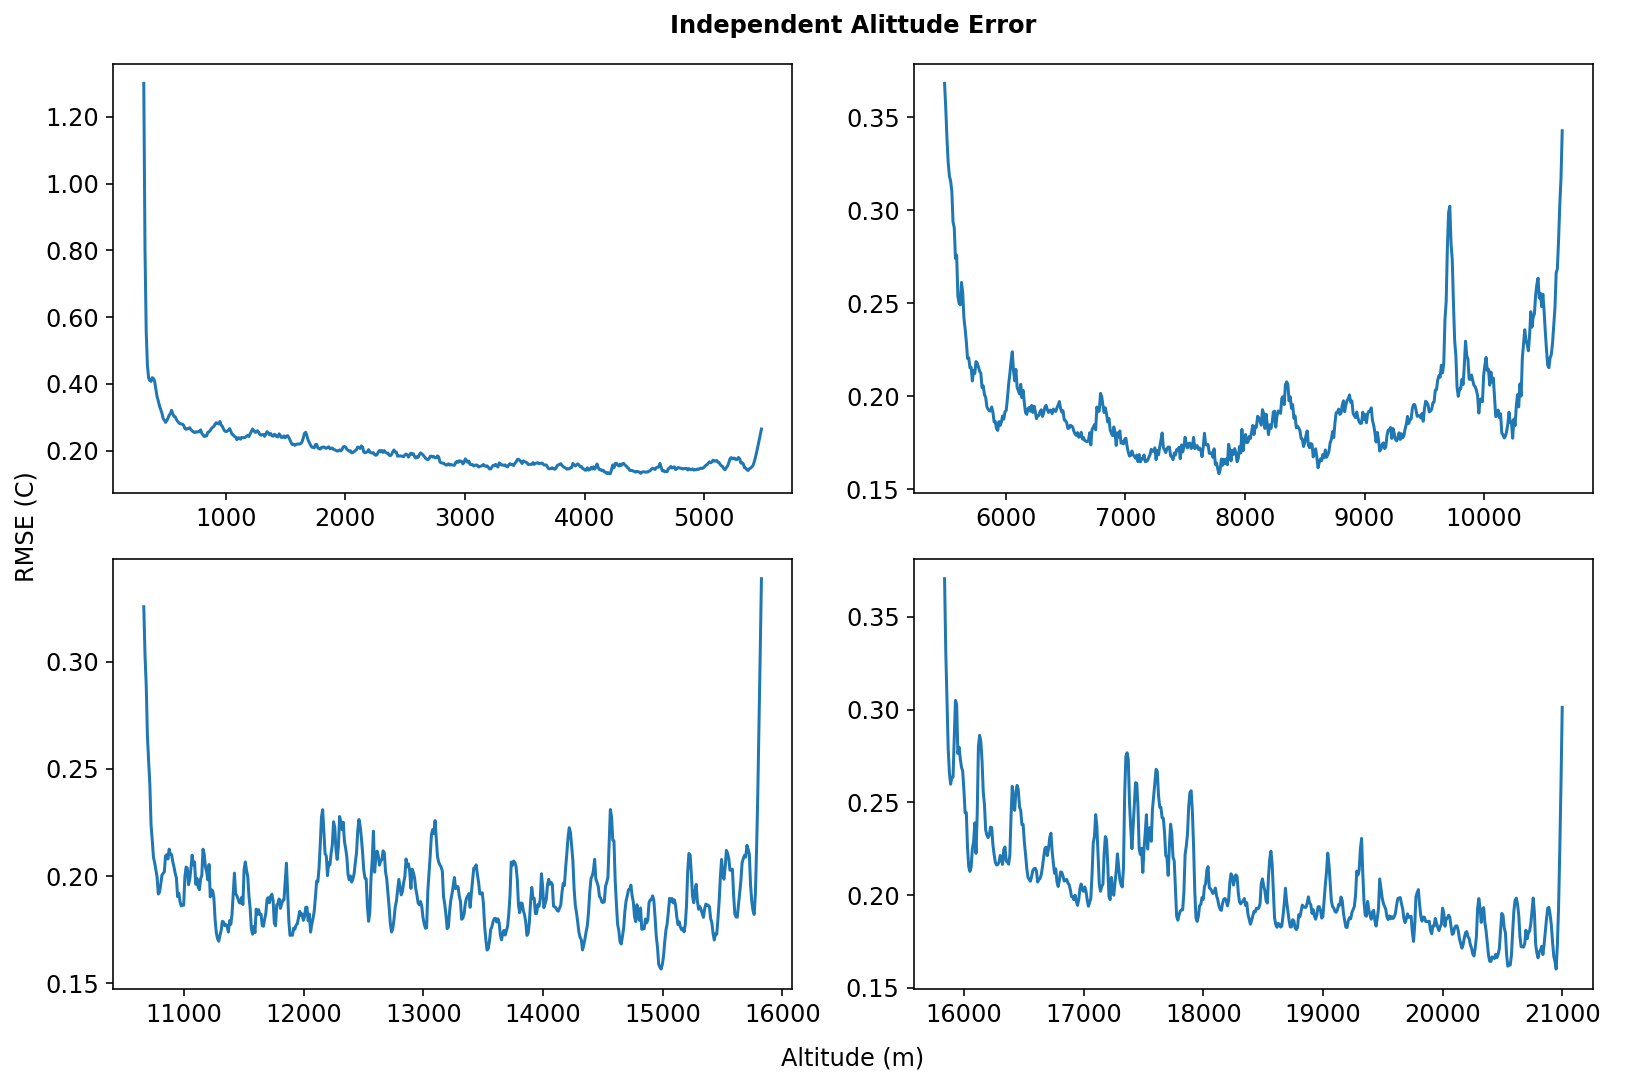

In [179]:
fig, axs = plt.subplots(steps//2, 2, figsize=(12, 8))
axs = axs.ravel()

start = 0
for i in range(steps):
    axs[i].plot(altitude_intervals[start:start+step_size], rmse_l[i])
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    start += step_size
    
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Altitude (m)', labelpad=10)
plt.ylabel('RMSE (C)', labelpad=11)
plt.title('Independent Alittude Error', y=1.02, fontweight='bold')

fig.tight_layout();

---
# Additional

In [ ]:
import metpy.calc

In [69]:
SONDE_PROFILE_DIMS = 256
alt_s = profiles[0][0, ALTITUDE] # 315
altitude_intervals = np.linspace(alt_s, alt_el, SONDE_PROFILE_DIMS)

In [70]:
interpolated_profiles = np.zeros((len(profiles), SONDE_PROFILE_DIMS, 4))
for i in range(len(profiles)):
    
    # remove duplicate values at surface level 
    alt_s = profiles[i][0, ALTITUDE]
    start_indx = 0
    for j in range(1, len(profiles[i][:, ALTITUDE])):
        if profiles[i][j, ALTITUDE] == alt_s:
            start_indx = j
        else:
            break
            
    p_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, PRESSURE], altitude_intervals)
    t_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, TEMPERATURE], altitude_intervals)
    td_n = interpolate_to_height_intervals(profiles[i][start_indx:, ALTITUDE], profiles[i][start_indx:, DEWPOINT], altitude_intervals)
    
    interpolated_profiles[i] = np.concatenate(([p_n], [t_n], [td_n], [altitude_intervals])).T

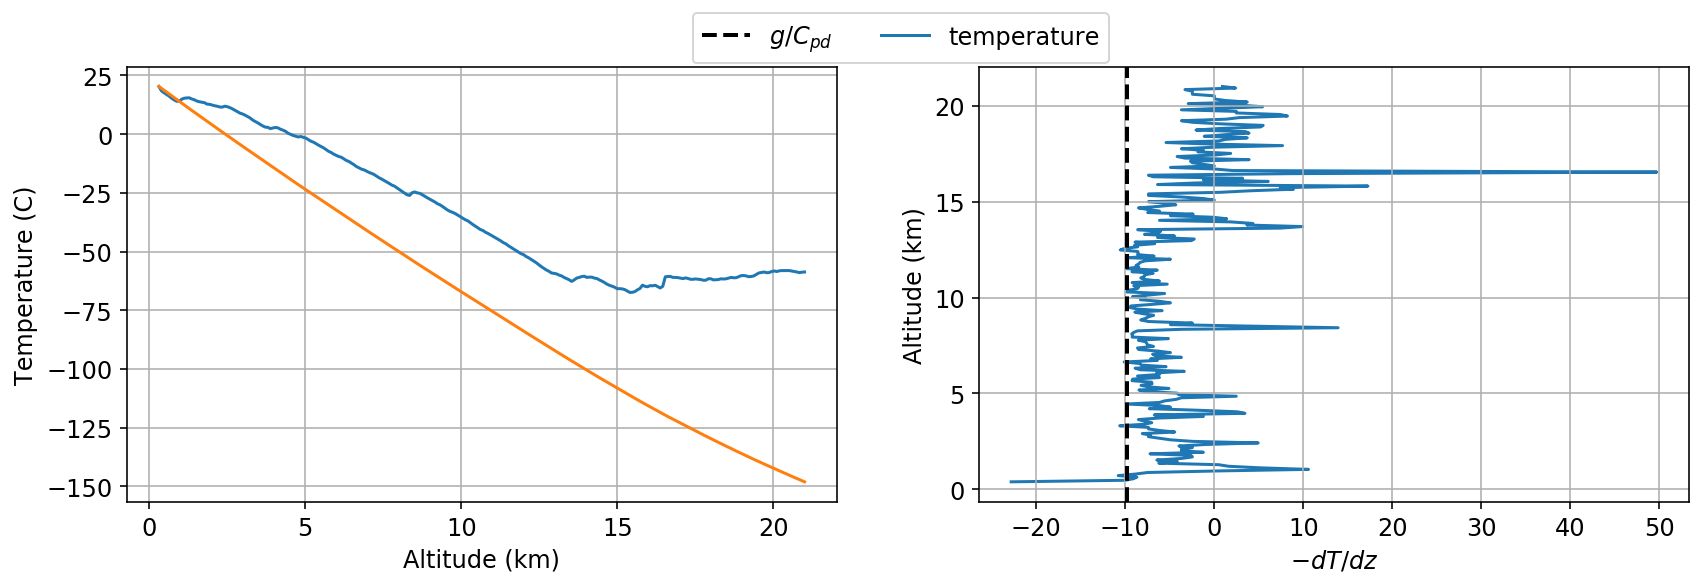

In [71]:
index = 2
p = interpolated_profiles[index,:,PRESSURE]
t = interpolated_profiles[index,:,TEMPERATURE]
alt = interpolated_profiles[index,:,ALTITUDE] / 1000

dry_lapse = metpy.calc.thermo.dry_lapse(p * metpy.units.units.hPa, 
                                        t[0] * metpy.units.units.degC).to('degC').m

deltas = []
deltas_lapse = []

alt_prev = 0
t_prev = 0
lapse_prev = 0

for alt_curr, t_curr, lapse_curr in zip(alt, t, dry_lapse):
    dT = t_curr - t_prev
    dZ = alt_curr - alt_prev
    deltas.append(dT/dZ)
    
    dTl = lapse_curr - lapse_prev
    deltas_lapse.append(dTl/dZ)
    
    alt_prev = alt_curr
    t_prev = t_curr
    lapse_prev = lapse_curr
    
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(alt, t)
axs[0].plot(alt, dry_lapse)
axs[0].grid(True)
axs[0].set_xlabel('Altitude (km)')
axs[0].set_ylabel('Temperature (C)')

axs[1].axvline(-9.76, label='$g/C_{pd}$', color='k', lw=2, ls='--', zorder=2)
axs[1].plot(deltas[1:], alt[1:], zorder=1, label='temperature')
axs[1].set_ylabel('Altitude (km)')
axs[1].set_xlabel('$-dT/dz$')
axs[1].grid(True)
axs.flatten()[-1].legend(loc='upper center', bbox_to_anchor=(-0.11, 1.15), ncol=3);

plt.savefig('sgp-adiabat', dpi=300)
plt.show();

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))